In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.1/871.1 kB 15.2 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

# 이미지 추론 함수
리턴 값
1. bbox 크롭된 이미지
2. binary mask

In [4]:
# %%writefile modules/get_box_and_mask.py
def extract_box(image, x1: int, y1: int, x2: int, y2: int): # -> ndarray:
    """
    주어진 좌표를 사용하여 이미지의 일부분을 추출합니다.

    Parameters:
    image (np.ndarray): 전체 이미지 배열
    x1, y1 (int): 좌상단 모서리 좌표
    x2, y2 (int): 우하단 모서리 좌표

    Returns:
    np.ndarray: 추출된 이미지 배열
    """
    # 이미지 배열에서 네모 박스 안의 부분을 추출
    cropped_image = image[y1:y2, x1:x2]

    return cropped_image


def infer_img(img_paths, model):
    """
    이미지, 모델 경로를 전달하면 객체를 검출해 bbox내 이미지 배열과 mask를 반환하는 함수

    Parameters
      img
      model

    Returns
      bbox_crop(ndarray) : 내 이미지 배열 크롭
      mask(ndarray)
    """
    from ultralytics import YOLO
    import matplotlib.pyplot as plt
    import numpy as np

    bbox_crop_all = []
    mask_all = []


    for img in img_paths:
      result = model.predict(img, save=False)[0]  # save = True - runs/segment/predict 하위에 추론 결과 이미지 저장

      # 바운딩박스 내의 이미지 크롭해서 리턴
      image= result.orig_img  # 원본 이미지(ndarray)
      xyxy = result.boxes.xyxy[0] # 바운딩 박스 좌표(좌상단xy, 우하단 xy)
      x1, y1, x2, y2 = [int(a) for a in xyxy]
      bbox_crop =extract_box(image, x1, y1, x2, y2)[:,:,::-1]

      # 바이너리 마스크 리턴
      # 바이너리 마스크 생성
      mask = result.masks.data[0]  # GPU 텐서
      mask_cpu = mask.cpu().numpy()  # CPU로 이동 후 NumPy 배열로 변환


      # mask = np.array(result.masks.data[0])
      mask_crop = extract_box(mask_cpu, x1, y1, x2, y2)

      bbox_crop_all.append(bbox_crop)
      mask_all.append(mask_crop)

    return bbox_crop_all, mask_all


In [5]:
#### 모델 복사

import zipfile
import os
import shutil

# 원본 파일 경로 (Google Drive 내의 파일)
# source_path = '/content/drive/MyDrive/이상감지/apples.zip'

source_path_1 = '/content/drive/MyDrive/이상감지/masks.pkl'
source_path_2 = '/content/drive/MyDrive/이상감지/bbox_crops.pkl'

# 복사할 대상 경로 (Colab 내의 작업 디렉토리)
# destination_path = '/content/apples.zip'
destination_path_1 = '/content/masks.pkl'
destination_path_2 = '/content/bbox_crops.pkl'

# 파일 복사
# shutil.copy(source_path, destination_path)
shutil.copy(source_path_1, destination_path_1)
shutil.copy(source_path_2, destination_path_2)

# print(f'File copied from {source_path} to {destination_path}')


# # 파일 경로와 압축 해제할 디렉토리 경로
zip_file_path = '/content/apples.zip'
unzip_dir = '/content/'

# 디렉토리가 없으면 생성
os.makedirs(unzip_dir, exist_ok=True)

# zip 파일 열고 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"압축 해제 완료: {unzip_dir}")





압축 해제 완료: /content/


In [ ]:
# train  - bbox, 마스크 추출

import glob
from ultralytics import YOLO

img_files = glob.glob('/content/apples/*.png')
model = YOLO(r"/content/best_2.pt")
len(img_files)
bbox_crops, masks =infer_img(img_files, model)


In [23]:
len(bbox_crops), len(masks)

(1000, 1000)

In [24]:
bbox_crops[0].shape, masks[0].shape

((543, 636, 3), (543, 636))

In [25]:
print(bbox_crops[0].shape, type(bbox_crops[0]))
print(masks[0].shape, type(masks[0]))

(543, 636, 3) <class 'numpy.ndarray'>
(543, 636) <class 'numpy.ndarray'>


In [ ]:
# import pickle

# # 피클 파일로 저장할 경로
# bbox_crops_path = '/content/bbox_crops.pkl'
# masks_path = '/content/masks.pkl'

# # 두 변수 리스트를 피클 파일로 저장
# with open(bbox_crops_path, 'wb') as f:
#     pickle.dump(bbox_crops, f)

# with open(masks_path, 'wb') as f:
#   pickle.dump(masks, f)

In [5]:
# 모델 pkl 로드

import pickle

bbox_crops_path = '/content/bbox_crops.pkl'
masks_path = '/content/masks.pkl'

# 피클 파일에서 데이터 로드
with open(bbox_crops_path, 'rb') as f:
    train_images = pickle.load(f)

with open(masks_path, 'rb') as f:
    train_masks = pickle.load(f)


In [6]:
print(type(train_images), len(train_images))
print(type(train_masks), len(train_masks))

<class 'list'> 1000
<class 'list'> 1000


In [7]:
train_images[0].shape, train_masks[0].shape

((543, 636, 3), (543, 636))

In [6]:
import os
import numpy as np
from typing import List
from fruit_reconstructor import train_and_save_models, load_models, infer, visualize_errors

# 경로 설정
test_image_path = '/content/image.npy'
test_mask_path = '/content/mask.npy'
clustering_model_path = '/content/clustering_model.pkl'
autoencoder_model_path = '/content/autoencoder_model.pth'

# 이전 노트북에서 생성한 train_images와 train_masks 변수 사용
# train_images: List[np.ndarray] = ...
# train_masks: List[np.ndarray] = ...

# 모델 파라미터 설정
clustering_params = {
    'n_clusters': 5,
    'color_space': 'LAB',
    'scaler_type': 'standard',
    'use_grid_mask': True
}
autoencoder_params = {
    'color_space': 'RGB',
    'scaler_type': 'minmax',
    'use_grid_mask': True,
    'epochs': 10,
    'batch_size': 32
}

# # 모델 훈련 및 저장
# train_and_save_models(train_images, train_masks, clustering_params, autoencoder_params,
#                       clustering_path=clustering_model_path, autoencoder_path=autoencoder_model_path)

# print("모델 훈련 및 저장 완료")



In [9]:
import os
import shutil
import zipfile

# 파일 복사
source_path_1 = '/content/drive/MyDrive/이상감지/autoencoder_model.pth'
source_path_2 = '/content/drive/MyDrive/이상감지/clustering_model.pkl'
source_path_3 = '/content/drive/MyDrive/이상감지/test_rotten_apple.zip'

destination_path_1 = '/content/autoencoder_model.pth'
destination_path_2 = '/content/clustering_model.pkl'
destination_path_3 = '/content/test_rotten_apple.zip'

shutil.copy(source_path_1, destination_path_1)
shutil.copy(source_path_2, destination_path_2)
shutil.copy(source_path_3, destination_path_3)

# 썩은 사과 이미지 zip 해제
zip_file_path =  '/content/test_rotten_apple.zip'
unzip_dir = '/content/test_rotten_apples/'

# 디렉토리가 없으면 생성
os.makedirs(unzip_dir, exist_ok=True)

# zip 파일 열고 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"압축 해제 완료: {unzip_dir}")



압축 해제 완료: /content/test_rotten_apples/


In [31]:
# test - bbox, 마스크 생성

import glob
from ultralytics import YOLO

img_files = glob.glob('/content/test_rotten_apples/test_rotten_apple/*.jpg')
model = YOLO(r"/content/best_2.pt")
len(img_files)
bbox_crops, masks =infer_img(img_files, model)



image 1/1 /content/test_rotten_apples/test_rotten_apple/rottenapple1.jpg: 640x448 1 apple, 34.5ms
Speed: 2.4ms preprocess, 34.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/test_rotten_apples/test_rotten_apple/rottenapple2.jpg: 480x640 1 apple, 35.7ms
Speed: 2.0ms preprocess, 35.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/test_rotten_apples/test_rotten_apple/rottenapple3.jpg: 640x640 3 apples, 46.7ms
Speed: 2.7ms preprocess, 46.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [24]:
# bbox와 마스크 shape 같은지 확인
bbox_crops[0].shape, masks[0].shape

# import matplotlib.pyplot as plt
# plt.imshow(masks[])

((1205, 1010, 3), (209, 377))

모델 불러오기 완료
추론 완료
Error Ratios:
Total Error Grids Ratio: 0.0005
Cluster Error Grids Ratio: 0.0008
Reconstruction Error Grids Ratio: 0.0033


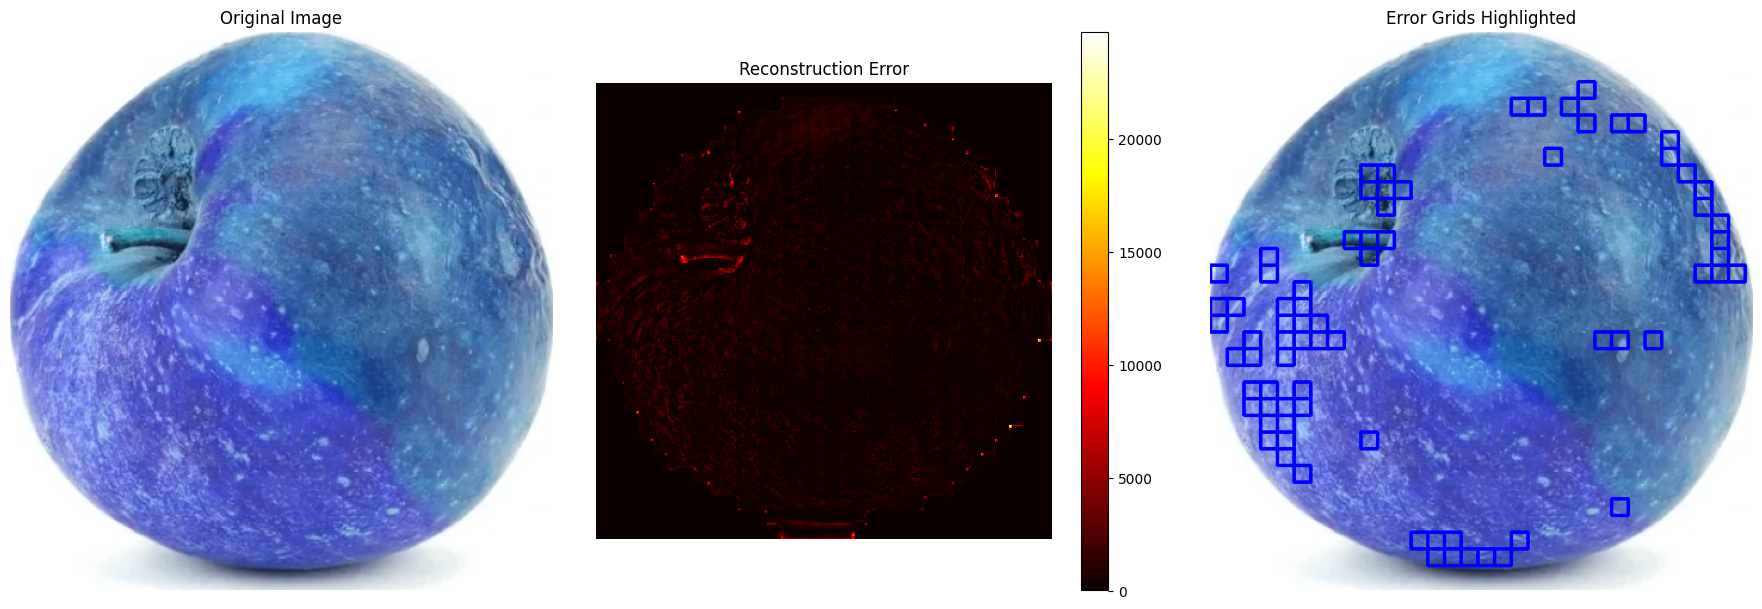

시각화 완료


In [32]:
from fruit_reconstructor import train_and_save_models, load_models, infer, visualize_errors


clustering_model_path = '/content/clustering_model.pkl'
autoencoder_model_path = '/content/autoencoder_model.pth'
# 모델 불러오기
clustering_model, autoencoder_model = load_models(clustering_path=clustering_model_path, autoencoder_path=autoencoder_model_path)

print("모델 불러오기 완료")

# 테스트 이미지와 마스크 불러오기
# test_image = np.load(test_image_path)
# test_mask = np.load(test_mask_path)
test_image = bbox_crops[1]
test_mask = masks[1]


clustering_params = {
    'color_space': 'LAB',

    'use_grid_mask': True
}
autoencoder_params = {
    'color_space': 'RGB',
    'use_grid_mask': True,

}


# 추론 수행
recon_error, grid_cluster, grid_error, error_ratios = infer(test_image, test_mask, clustering_model, autoencoder_model,
                                                              clustering_params, autoencoder_params)

print("추론 완료")
print("Error Ratios:")
print(f"Total Error Grids Ratio: {error_ratios[0]:.4f}")
print(f"Cluster Error Grids Ratio: {error_ratios[1]:.4f}")
print(f"Reconstruction Error Grids Ratio: {error_ratios[2]:.4f}")

# 결과 시각화
visualize_errors(test_image, recon_error, grid_cluster, grid_error)

print("시각화 완료")


# 업데이트한 모듈 다운로드

In [12]:
### 학습 후 모델 다운로드

from google.colab import files
# 다운로드할 파일 경로 설정
clustering_model_path = '/content/clustering_model.pkl'
autoencoder_model_path = '/content/autoencoder_model.pth'

# 파일 다운로드
files.download(clustering_model_path)
files.download(autoencoder_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# 업데이트한 모듈 다운로드
from google.colab import files

# 파일 다운로드
files.download("/content/autoencoder_module.py")
files.download("/content/clustering_module.py")
files.download("/content/fruit_reconstructor.py")
files.download("/content/image_processing_utils.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>